We would like to explore Random Forest Regressors and Support Vector Machines along with some input variables to see if we can make a model that accurately forecasts energy demand. We aim to achieve better results than simply saying 'The demand in 30 minutes time will be the same as it is right now'. This is calculated below as having a mean average loss of 218.

In [1]:
# Suppress annoying deprecation warnings
from warnings import filterwarnings  # noqa
filterwarnings(action='ignore',
                        category=DeprecationWarning,
                        module='sklearn')  # noqa

# Import libraries
import os, sys
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
from pprint import pprint
from sklearn.metrics import make_scorer
from datetime import datetime, timedelta
from sklearn.svm import SVR
from matplotlib import pyplot as plt
import forestci as fci

## Set path to current directory
#sys.path.append(os.path.abspath(os.getcwd()))

## read data
data = pd.read_csv('F:/Users/Dave/Desktop/UNSW-Capstone-Group-E/src/chrisdavid/Cleaned_Data_mkII.csv')

# Set random state
STATE = 69

# If set to true, models will perform hyperparameter tuning. If false they will use
# pre-defined values
SEARCH = False

# Makes sure datetime is in datetime format
data['DATETIME'] = pd.to_datetime(data['DATETIME'])

# We want to test a time column as an input
data['time'] = (data['DATETIME'].dt.strftime("%H%M%S"))

# Also would like to test demand and tmeperature 30, 60 and 90 mins before the current time as input
# These were found to have diminishing return after 60 mins out for demand and 30 mins out for temp
data['demand_30'] = data.TOTALDEMAND.shift(1)
data['demand_60'] = data.TOTALDEMAND.shift(2)
data['demand_90'] = data.TOTALDEMAND.shift(3)

data['temp_30'] = data.TEMPERATURE.shift(1)
data['temp_60'] = data.TEMPERATURE.shift(2)
data['temp_90'] = data.TEMPERATURE.shift(3)

# Select data from the past 5 years
mask = (data['DATETIME'] >= '2016-01-01') & (data['DATETIME'] < '2021-01-01')
data = data.loc[mask]

## How accurate would it be to use demand 30 mins ago as a prediciton for demand now?
#round(math.sqrt(mean_squared_error(data['TOTALDEMAND'], data['demand_30'])))


# And an indictor if it is a weekend or not
data['is_weekday'] = data['DATETIME'].dt.weekday
data['is_weekday'] = np.where(data['is_weekday'] < 5, 1, 0)

# import weather data
weather = pd.read_csv('F:/Users/Dave/Desktop/UNSW-Capstone-Group-E/src/chrisdavid/weather.csv')

# Convert datetime to date
weather['date'] = pd.to_datetime(weather[['Year','Month','Day']]).dt.date

# Extract just day and rain columns
weather.columns = ['drop1','drop2','drop3','drop4','drop5','rain','drop6','drop7','date']
weather = weather[['date','rain']]

# Fill NA values
weather['rain'].fillna(method = 'ffill', inplace = True)

## Create dummy variables for rain for better model use
#weather['RAIN'] = pd.cut(weather['rain'],bins=[-1,0.2,4,10,999999],labels=['NONE','LIGHT','MODERATE','HEAVY'])
#weather_dummy = pd.get_dummies(weather,columns=['RAIN'])

# Create day column in data and merge using it
data['date'] = data['DATETIME'].dt.date

data = data.merge(weather, on = 'date')

data['day'] = data['DATETIME'].dt.day
data['month'] = data['DATETIME'].dt.month

C:\ProgramData\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


After creating a data frame with all of the features that we deem potentially interesting, we would like to evaluate their suitability for use in a random forest regressor. To do feature selection we will use mutual information (information gain of each input in relation to the output variable) as a selection metric.

In [ ]:
# This code takes ages to run
#filterwarnings(action='ignore',
#                        category=DeprecationWarning,
#                        module='sklearn')  # noqa
#
#from sklearn.feature_selection import mutual_info_regression  
#from sklearn.feature_selection import SelectKBest
#
#Y = data['TOTALDEMAND']
#X = data.drop(columns = ['TEMPERATURE', 'TOTALDEMAND', 'DATETIME', 'date'])
#
#selector = SelectKBest(mutual_info_regression, k = 'all')
#
#X_train_new = selector.fit_transform(X, Y)  
#mask = selector.get_support()
#
#new_features = X.columns[mask]
#
#for i in range(len(new_features)):
#    print('Score: ', selector.scores_[i], 'Feature: ', new_features[i])

From this, we can see that time, demand_30, demand_60, demand_90, temp_30, temp_60, temp_90 and month are all potentially useful in a model.

In [ ]:
# Create features and target sets
base_features = data[['time', 'demand_30', 'demand_60', 'demand_90', 'temp_30', 'temp_60' ,'temp_90', 'month']]
base_target = data['TOTALDEMAND']

# Convert to numpy arrays and split training/test data
base_features_np = pd.DataFrame(base_features).to_numpy()
base_target_np = np.ravel(pd.DataFrame(base_target).to_numpy())

base_features_train, base_features_test, base_target_train, base_target_test = train_test_split(base_features_np,
                                                                            base_target_np, random_state = STATE)

# Implement Random Forest
base_rnd_clf = RandomForestRegressor(random_state = STATE, criterion = 'absolute_error')
base_rnd_clf.fit(base_features_train, base_target_train)

# Print error
base_rf_predicted = base_rnd_clf.predict(base_features_test)
base_rf_MAE = mean_absolute_error(base_target_test, base_rf_predicted)
#base_rf_error = round(math.sqrt(mean_squared_error(base_target_test, base_rf_predicted)))
print("Baseline Random Forest MAE: ", base_rf_MAE)

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(base_rnd_clf.get_params())

This is actually quite a good model performance. We suspect that there is a very high correlation between the demand and temperature variables, so we will try eliminating some of these with the suspicion that dropping them will not drastically effect the model performance.

In [2]:
# Create features and target sets
features = data[['time', 'demand_30', 'demand_60', 'temp_30']]
target = data['TOTALDEMAND']

# Convert to numpy arrays and split training/test data
features_np = pd.DataFrame(features).to_numpy()
target_np = np.ravel(pd.DataFrame(target).to_numpy())

features_train, features_test, target_train, target_test = train_test_split(features_np,
                                                                            target_np, random_state = STATE)

In [3]:
# Implement Random Forest
rnd_clf = RandomForestRegressor(random_state = STATE, criterion = 'absolute_error')
rnd_clf.fit(features_train, target_train)

# Print error
rf_predicted = rnd_clf.predict(features_test)
rf_MAE = mean_absolute_error(target_test, rf_predicted)
print("Baseline Random Forest MAE: ", rf_MAE)

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rnd_clf.get_params())

Baseline Random Forest MAE:  56.98646279191751
Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'absolute_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 69,
 'verbose': 0,
 'warm_start': False}


We have managed to eliminate most of the remaining inputs. We have; time, demand_30, demand_60 and temp_30 as useful to our model.

Let's try random search of optimizing hyperparamters as a quick way to tell if our baseline model can perform any better.

In [ ]:
###### Only run this code if you want to sit around for 30 mins

# Tune hyperparameters
# Create the random grid
random_grid = {'n_estimators': list(range(12, 24, 2)),
               'criterion': ['mae'],
               'max_features': ['auto'],
               'max_depth': list(range(1, 20, 1)),
               'min_samples_split': list(range(5, 9, 1)),
               'min_samples_leaf': list(range(2, 10, 1)),
               'bootstrap': [True]}


rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = random_grid, 
                               n_iter = 3, cv = 3, verbose = 2, random_state = STATE, n_jobs = -1)

rf_random.fit(features_train, target_train)

## Print error
rf_random_pred = rf_random.best_estimator_.predict(features_test)
rf_random_MAE = mean_absolute_error(target_test, rf_random_pred)
print("Baseline Random Forest MAE: ", rf_random_MAE)

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf_random.best_params_)

This tuning is only a little better than our base model. No point in continuing hyperparpmeter tuning further, or in continuing with the model, unless we can think of other inputs.

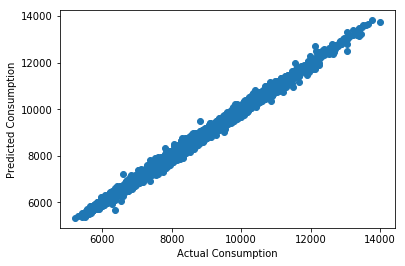

In [21]:
# Plot predicted vs actual without error bars
plt.scatter(target_test, rf_predicted)
plt.plot()
plt.xlabel('Actual Consumption')
plt.ylabel('Predicted Consumption')
plt.show()

In [10]:
# Calculate the variance
rf_var = fci.random_forest_error(rnd_clf, features_train, features_test)


KeyboardInterrupt: 

In [22]:
# Plot error bars for predicted MPG using unbiased variance
plt.errorbar(target_test, rf_predicted, yerr=np.sqrt(rf_var), fmt='o')
plt.plot()
plt.xlabel('Actual Consumption')
plt.ylabel('Predicted Consumption')
plt.show()

NameError: name 'rf_var' is not defined

We will now start with SVM modelling

In [ ]:
# Implement Support Vector Machine Regressor


regressor = SVR(kernel = 'linear')
regressor.fit(features_train, target_train)

# Print error
svm_predicted = regressor.predict(features_test)
svm_MAE = mean_absolute_error(target_test, svm_predicted)
print("SVM MAE: ", svm_MAE)

In [ ]:
SVM_param_grid = {'C' : [0.1, 1, 10, 100, 1000],
                 'gamma' : [1, 0.1, 0.01, 0.001, 0.0001],
                 'kernel' : ['poly', 'rbf']}

scorer = make_scorer(mean_absolute_error, greater_is_better = False)

svr_gs = GridSearchCV(SVR(), SVM_param_grid, scoring=scorer)
svr_gs.fit(features_train, target_train)

grid_preds = svr_gs.predict(features_test)
best_SVM_grid_error = round(math.sqrt(mean_squared_error(base_target_test, grid_preds)))

# Print error
#print("SVM Grid Search Tuning Error: ", best_SVM_grid_error)

# Look at parameters used
#print('Parameters currently in use:\n')
#pprint(svr_gs.get_params())


In [ ]:
# Calculate RMSE for each model and benchmark
# Lower = better model

rf_error = round(math.sqrt(mean_squared_error(target_test, rf_predicted)))
svm_error = round(math.sqrt(mean_squared_error(target_test, svm_predicted)))
benchmark_error = round(math.sqrt(mean_squared_error(data['TOTALDEMAND'], data['demand_30'])))

print("FINAL SCORES")
print("Untuned Random Forest Error: ", rf_error)
print("Tuned Random Forest Error: ", best_random_error)
print("Untuned SVM Error: ", svm_error)
print("Tuned SVM Error: ", best_SVM_grid_error)
print("Benchmark Error: ", benchmark_error)

In [ ]:

predictions = list(rf_random.predict(base_features_np))
targets = list(base_target_np)
output = pd.DataFrame({'prediction':predictions,'target':targets})
output.to_csv('output_rf.csv')